In [75]:
from dotenv import load_dotenv
load_dotenv()

True

In [76]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from typing import Literal
from langchain import hub
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.prebuilt import ToolNode

In [77]:

embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [78]:


llm = ChatOpenAI(model='gpt-4o', streaming=True)
small_llm = ChatOpenAI(model='gpt-4o-mini', streaming=True)

In [79]:
# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding,
#     collection_name="chroma_tax",
#     persist_directory="./chroma_tax"
# )

vector_store = Chroma(
    collection_name="chroma_tax",
    embedding_function=embedding,
    persist_directory="./chroma_tax"
)

In [80]:
retriever = vector_store.as_retriever(search_kwargs={"k" : 3})
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x000002867B4CC090>, search_kwargs={'k': 3})

In [81]:
# from typing_extensions import List, TypedDict
# from langchain_core.documents import Document
# from langgraph.graph import StateGraph, MessagesState
# from typing import Literal
# # 기존 import 수정
# from typing_extensions import TypedDict  # ✅ typing 대신 typing_extensions 사용

# class AgentState(TypedDict):
#     query: str
#     context: List[Document]     #retriever에 있는 문서에서 읽어오겠다
#     answer : str
    
graph_builder = StateGraph(MessagesState)

In [82]:
# from langchain_core.tools import tool
# from langgraph.graph import MessagesState
# from langchain_core.messages import SystemMessage

@tool
def retrieve_documents(query: str) -> str:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.
    
    Args:
        query (str): 검색할 질문
        
    Returns:
        str: 검색된 문서 내용
    """
    docs = retriever.invoke(query)
    doc_content = "\n\n".join([doc.page_content for doc in docs])
    return f"검색된 관련 문서:\n{doc_content}"

In [83]:
@tool
def check_document_relevance(query: str, documents: str) -> str:
    """
    검색된 문서가 질문과 관련이 있는지 확인합니다.
    
    Args:
        query (str): 사용자 질문
        documents (str): 검색된 문서
        
    Returns:
        str: 'relevant' 또는 'not_relevant'
    """
    doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")
    doc_relevance_chain = doc_relevance_prompt | llm
    
    try:
        response = doc_relevance_chain.invoke({'question': query, 'documents': documents})
        # 응답에서 점수 추출 (실제 구현에 따라 조정 필요)
        if hasattr(response, 'content') and '1' in response.content:
            return 'relevant'
        else:
            return 'not_relevant'
    except:
        return 'relevant'  # 기본값

In [84]:
@tool
def rewrite_query(query: str) -> str:
    """
    사용자의 질문을 사전을 고려하여 변경합니다.
    
    Args:
        query (str): 원본 질문
        
    Returns:
        str: 개선된 질문
    """
    dictionary = ["사람과 관련된 표현 -> 거주자"]
    
    rewrite_prompt = PromptTemplate.from_template(f"""
    사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
    사전: {dictionary}
    질문: {{query}}
    """)
    
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return response

In [85]:
# 도구 리스트와 ToolNode 생성

tool_list = [retrieve_documents, check_document_relevance, rewrite_query]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

# 그래프 구성
graph_builder = StateGraph(MessagesState)

In [86]:
@tool
def generate_answer(query: str, context: str) -> str:
    """
    주어진 질문과 문맥을 기반으로 답변을 생성합니다.
    
    Args:
        query (str): 사용자 질문
        context (str): 검색된 문서 내용
        
    Returns:
        str: 생성된 답변
    """
    generate_prompt = hub.pull('rlm/rag-prompt')
    rag_chain = generate_prompt | llm
    
    response = rag_chain.invoke({
        'question': query,
        'context': context,
    })
    
    return response.content if hasattr(response, 'content') else str(response)

In [87]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와 
    LLM과 도구를 사용하여 응답메시지를 생성합니다.
    """
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메시지 상태를 기반으로 에이전트가 계속 진행할 지 여부를 결정한다.
    """
    messages = state['messages']
    last_ai_message = messages[-1]

    if last_ai_message.tool_calls:
        return 'tools'
    return END

def generate_final_answer(state: MessagesState) -> MessagesState:
    """
    최종 답변을 생성하는 함수
    """
    messages = state['messages']
    
    # 사용자 질문과 검색된 문서 찾기
    user_query = ""
    documents = ""
    
    for msg in messages:
        if isinstance(msg, HumanMessage):
            user_query = msg.content
        elif hasattr(msg, 'content') and "검색된 관련 문서" in str(msg.content):
            documents = msg.content
    
    # RAG 프롬프트로 최종 답변 생성
    if documents:
        generate_prompt = hub.pull('rlm/rag-prompt')
        rag_chain = generate_prompt | llm
        
        response = rag_chain.invoke({
            'question': user_query,
            'context': documents,
        })
        
        return {"messages": [response]}
    else:
        # 문서가 없으면 일반 답변
        response = llm.invoke(messages)
        return {"messages": [response]}

In [88]:

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node('generate_answer', generate_final_answer)

# 엣지 추가
graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', 'generate_answer']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('generate_answer', END)

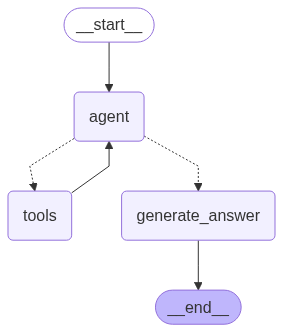

In [89]:
graph = graph_builder.compile()
graph

In [90]:
for chunk in graph.stream({'messages': [HumanMessage('연봉 5천만원 직장인의 소득세는?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()


================================ Human Message =================================

연봉 5천만원 직장인의 소득세는?
================================== Ai Message ==================================
Tool Calls:
  rewrite_query (call_YEgwL7yORUE6lGX5JbiPzMf0)
 Call ID: call_YEgwL7yORUE6lGX5JbiPzMf0
  Args:
    query: 연봉 5천만원 직장인의 소득세는?
================================= Tool Message =================================
Name: rewrite_query

거주자 연봉 5천만원의 소득세는?
================================== Ai Message ==================================
Tool Calls:
  retrieve_documents (call_cwL2EGibdYHEvVTQLcD59NCa)
 Call ID: call_cwL2EGibdYHEvVTQLcD59NCa
  Args:
    query: 거주자 연봉 5천만원의 소득세는?
================================= Tool Message =================================
Name: retrieve_documents

검색된 관련 문서:
제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>

| 종합소득 과세표준          | 세율                

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================= Tool Message =================================
Name: check_document_relevance

not_relevant
================================== Ai Message ==================================
Tool Calls:
  retrieve_documents (call_cva50Xzs8ZJaEIUEbvZUsJeT)
 Call ID: call_cva50Xzs8ZJaEIUEbvZUsJeT
  Args:
    query: 연봉 5000만원 소득세 계산
================================= Tool Message =================================
Name: retrieve_documents

검색된 관련 문서:
1. 「공익신탁법」에 따른 공익신탁의 이익

2. 사업소득 중 다음 각 목의 어느 하나에 해당하는 소득

가. 논ㆍ밭을 작물 생산에 이용하게 함으로써 발생하는 소득

나. 1개의 주택을 소유하는 자의 주택임대소득(제99조에 따른 기준시가가 12억원을 초과하는 주택 및 국외에 소재하는 주택의 임대소득은 제외한다) 또는 해당 과세기간에 대통령령으로 정하는 총수입금액의 합계액이 2천만원 이하인 자의 주택임대소득(2018년 12월 31일 이전에 끝나는 과세기간까지 발생하는 소득으로 한정한다). 이 경우 주택 수의 계산 및 주택임대소득의 산정 등 필요한 사항은 대통령령으로 정한다.

다. 대통령령으로 정하는 농어가부업소득

라. 대통령령으로 정하는 전통주의 제조에서 발생하는 소득

마. 조림기간 5년 이상인 임지(林地)의 임목(林木)의 벌채 또는 양도로 발생하는 소득으로서 연 600만원 이하의 금액. 이 경우 조림기간 및 세액의 계산 등 필요한 사항은 대통령령으로 정한다.

바. 대통령령으로 정하는 작물재배업에서 발생하는 소득

사. 대통령령으로 정하

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================= Tool Message =================================
Name: check_document_relevance

not_relevant
================================== Ai Message ==================================
Tool Calls:
  retrieve_documents (call_Y9Rmms7b2g9VA4D3FjhcAbhY)
 Call ID: call_Y9Rmms7b2g9VA4D3FjhcAbhY
  Args:
    query: 소득세율 연봉 5000만원
================================= Tool Message =================================
Name: retrieve_documents

검색된 관련 문서:
제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>

| 종합소득 과세표준          | 세율                                         |

|-------------------|--------------------------------------------|

| 1,400만원 이하     | 과세표준의 6퍼센트                             |

| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |

| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |

| 8,800만원 초과 1억5천만원 이하

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================= Tool Message =================================
Name: check_document_relevance

not_relevant
================================== Ai Message ==================================
Tool Calls:
  retrieve_documents (call_Pp3DEB4roBm0OL7yIB3UAbIu)
 Call ID: call_Pp3DEB4roBm0OL7yIB3UAbIu
  Args:
    query: 5000만원 소득세
================================= Tool Message =================================
Name: retrieve_documents

검색된 관련 문서:
④ 관할세무서장 또는 지방국세청장은 주소ㆍ거소 또는 사업장의 이동이 빈번하다고 인정되는 지역의 납세의무가 있는 자에 대해서는 제1항과 제2항을 준용하여 대통령령으로 정하는 바에 따라 수시부과할 수 있다.

⑤ 수시부과 절차와 그 밖에 필요한 사항은 대통령령으로 정한다.

[전문개정 2009. 12. 31.]



제83조(과세표준과 세액의 통지) 납세지 관할 세무서장 또는 지방국세청장은 제80조에 따라 거주자의 과세표준과 세액을 결정 또는 경정한 경우에는 그 내용을 해당 거주자 또는 상속인에게 대통령령으로 정하는 바에 따라 서면으로 통지하여야 한다. 다만, 제42조에 따라 과세표준과 세액의 결정 또는 경정을 한 경우에는 지체 없이 통지하여야 한다.

[전문개정 2009. 12. 31.]



제84조(기타소득의 과세최저한) 기타소득이 다음 각 호의 어느 하나에 해당하면 그 소득에 대한 소득세를 과세하지 아니한다. <개정 2014. 12. 23., 2015. 12. 15., 2022. 12. 31.>

1. 제21조제1항제4호에 따른 환급금으로서 건별로 

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================= Tool Message =================================
Name: check_document_relevance

not_relevant
================================== Ai Message ==================================
Tool Calls:
  retrieve_documents (call_5hFm8ma24arHdiDvYo6f1dGI)
 Call ID: call_5hFm8ma24arHdiDvYo6f1dGI
  Args:
    query: 소득세 5000만원
================================= Tool Message =================================
Name: retrieve_documents

검색된 관련 문서:
④ 관할세무서장 또는 지방국세청장은 주소ㆍ거소 또는 사업장의 이동이 빈번하다고 인정되는 지역의 납세의무가 있는 자에 대해서는 제1항과 제2항을 준용하여 대통령령으로 정하는 바에 따라 수시부과할 수 있다.

⑤ 수시부과 절차와 그 밖에 필요한 사항은 대통령령으로 정한다.

[전문개정 2009. 12. 31.]



제83조(과세표준과 세액의 통지) 납세지 관할 세무서장 또는 지방국세청장은 제80조에 따라 거주자의 과세표준과 세액을 결정 또는 경정한 경우에는 그 내용을 해당 거주자 또는 상속인에게 대통령령으로 정하는 바에 따라 서면으로 통지하여야 한다. 다만, 제42조에 따라 과세표준과 세액의 결정 또는 경정을 한 경우에는 지체 없이 통지하여야 한다.

[전문개정 2009. 12. 31.]



제84조(기타소득의 과세최저한) 기타소득이 다음 각 호의 어느 하나에 해당하면 그 소득에 대한 소득세를 과세하지 아니한다. <개정 2014. 12. 23., 2015. 12. 15., 2022. 12. 31.>

1. 제21조제1항제4호에 따른 환급금으로서 건별로 

KeyError: '__end__'